# Predictive Analytics Sewa Apartment

Nama: Ahmad Radesta

Username: ahmad007

---


## 1.Domain Proyek

Ketersediaan informasi sewa apartemen yang akurat dan relevan menjadi tantangan besar bagi calon penyewa. Dengan semakin banyaknya platform iklan properti, informasi yang tersedia seringkali tidak terstruktur, tidak lengkap, dan sulit dibandingkan antar penawaran.

> Referensi:  
> Si, R. & Lu, Min & Arikawa, Masatoshi & Asami, Yasushi & Iwasaki, J.. (2014). Finding Good Areas for Renting Apartments Using Apartments Information and Users' Trajectories. ISPRS - International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences. XL-4. 10.5194/isprsarchives-XL-4-229-2014.

> Sirmans, G. & Benjamin, John. (1991). Determinants of Market Rent. Journal of Real Estate Research. 6. 357-380.
10.1080/10835547.1991.12090653.

## 2.Business Understanding

### Problem Statements
1. Harga sewa apartemen yang tercantum di iklan seringkali tidak mencerminkan nilai pasar aktual.
2. Sulit bagi pemilik atau penyewa untuk menentukan apakah harga tersebut wajar atau tidak.

### Goals
Membangun model machine learning untuk memprediksi harga sewa apartemen berdasarkan fitur-fitur seperti lokasi, ukuran, jumlah kamar, dan deskripsi properti.


### Solution Statement
- **Ridge Regression** dan **Lasso Regression**  
  Model regresi linier dengan regularisasi (L2 dan L1) digunakan sebagai baseline. Model ini mudah diinterpretasikan dan cepat dalam pelatihan, serta mampu menangani multikolinearitas.
- **Random Forest Regressor**, **Gradient Boosting**, **XGBoost**, **CatBoost**, dan **LightGBM**  
  Kelompok model ensemble yang mampu menangkap hubungan non-linear antara fitur dan harga sewa. XGBoost dan LightGBM dikenal cepat dan akurat, sementara CatBoost menangani fitur kategori secara efisien.
- **RMSE (Root Mean Squared Error)** – untuk mengukur kesalahan prediksi

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


### 🏷️ One-Hot Encoding
Mengubah fitur kategorikal menjadi format numerik biner untuk modeling.

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.stats import probplot, boxcox
import pylab
from sklearn.feature_selection import VarianceThreshold
import collections
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import inv_boxcox

## 3.Data Understanding

Dataset diambil dari [Apartments for Rent Classified](https://www.kaggle.com/datasets/adithyaawati/apartments-for-rent-classified).

**Informasi Dataset**

- File: apartments_for_rent_classified_100K.csv

### Informasi Dataset
- **File:** `apartments_for_rent_classified_100K.csv`
- **Jumlah data:** ~100.000 baris
- **Fitur utama:** `price`, `bedrooms`, `bathrooms`, `size_sqft`, `location`, `description`, `category`

### Kondisi Data
- Terdapat missing value pada beberapa kolom
- Distribusi harga tidak normal (ada outlier ekstrem)

### Penjelasan Fitur
- `price`: target prediksi
- `bedrooms`, `bathrooms`, `size_sqft`: fitur numerik
- `location`, `description`: fitur kategori/teks
- `category`: jenis unit (apartment, studio, dll)

### EDA *(Rubrik Tambahan)*
- Korelasi fitur terhadap harga
- Distribusi harga berdasarkan lokasi
- Word frequency dari deskripsi properti


### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [6]:
# from google.colab import files
# uploaded = files.upload()  # upload file music.zip

Saving archive.zip to archive.zip


### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [8]:
!unzip archive.zip -d apartment_dataset

Archive:  archive.zip
  inflating: apartment_dataset/apartments_for_rent_classified_100K/apartments_for_rent_classified_100K.csv  
  inflating: apartment_dataset/apartments_for_rent_classified_10K/apartments_for_rent_classified_10K.csv  


### 📥 Membaca Dataset
Dataset utama dibaca ke dalam DataFrame untuk analisis lebih lanjut.

In [9]:
df = pd.read_csv("/content/apartment_dataset/apartments_for_rent_classified_10K/apartments_for_rent_classified_10K.csv", sep=";", encoding='cp1252')

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [10]:
print("Jumlah data",df.shape)

Jumlah data (10000, 22)


### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [11]:
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


### 🧾 Melihat Struktur Data
Menampilkan informasi umum dari dataset, seperti jumlah non-null dan tipe data.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  state          9923 non-null   object 
 18  latitud

| | Tipe Data | Jumlah Missing Value |
|----------|----------|----------|
|amenities|object|3549
|bathrooms|float64|34
|bedrooms|float64|7
|pets_allowed|bject|4163
|address|object|3327
|cityname|object|77
|state|object|77
|latitude|float64|10
|longitude|float64|10

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [13]:
# Menghitung jumlah kolom bertipe kategorikal dan numerik dari dataset
from typing import Tuple

def hitung_jumlah_kolom(df) -> Tuple[int, int]:
    # Ambil kolom bertipe kategorikal (objek/string)
    kolom_kategorikal = df.select_dtypes(include=['object']).columns
    jumlah_kategorikal = len(kolom_kategorikal)

    # Ambil kolom bertipe numerik
    kolom_numerik = df.select_dtypes(exclude=['object']).columns
    jumlah_numerik = len(kolom_numerik)

    return jumlah_kategorikal, jumlah_numerik

# Hitung dan tampilkan hasilnya
jumlah_kat, jumlah_num = hitung_jumlah_kolom(df)
print("Jumlah kolom kategorikal:", jumlah_kat)
print("Jumlah kolom numerik:", jumlah_num)


Jumlah kolom kategorikal: 14
Jumlah kolom numerik: 8


### 📊 Statistik Deskriptif
Melihat ringkasan statistik numerik dari dataset.

In [14]:
df.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,1.000000e+04,9966.000000,9993.000000,10000.000000,10000.000000,9990.000000,9990.000000,1.000000e+04
mean,5.623396e+09,1.380544,1.744021,1486.277500,945.810500,37.695162,-94.652247,1.574891e+09
std,7.021025e+07,0.615410,0.942354,1076.507968,655.755736,5.495851,15.759805,3.762395e+06
min,5.508654e+09,1.000000,0.000000,200.000000,101.000000,21.315500,-158.022100,1.568744e+09
25%,5.509248e+09,1.000000,1.000000,949.000000,649.000000,33.679850,-101.301700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1270.000000,802.000000,38.809800,-93.651600,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.349800,-82.209975,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.594000,-70.191600,1.577362e+09


## 4.Data Preparation

### Langkah-Langkah
- Handling missing values (median imputation untuk numerik, `'unknown'` untuk kategori)
- **Feature engineering:**
  - Ekstraksi keyword dari `description`
  - Encoding lokasi menggunakan One-Hot/Target Encoding
- Normalisasi numerik (opsional untuk model linear)

### Alasan Tahapan
- Menghindari bias dari data tidak lengkap
- Mengubah fitur teks menjadi representasi numerik
- Memastikan model dapat belajar dari representasi yang konsisten

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [15]:
# Identifikasi kolom yang mengandung nilai null
kolom_dengan_null = df.columns[df.isna().any()].tolist()

# Buat DataFrame ringkasan untuk menampilkan tipe data dan jumlah nilai null pada kolom-kolom tersebut
info_null = pd.DataFrame({
    'Tipe Kolom': df[kolom_dengan_null].dtypes,
    'Total Null': df[kolom_dengan_null].isna().sum()
})

print("Daftar kolom yang mengandung nilai null dan tipe datanya:")
print(info_null)


Daftar kolom yang mengandung nilai null dan tipe datanya:
             Tipe Kolom  Total Null
amenities        object        3549
bathrooms       float64          34
bedrooms        float64           7
pets_allowed     object        4163
address          object        3327
cityname         object          77
state            object          77
latitude        float64          10
longitude       float64          10


### 🧹 Penghapusan Kolom atau Baris
Menghapus kolom/baris yang dianggap tidak relevan atau memiliki banyak missing value.

In [16]:
# Salin dataset untuk menjaga data asli tetap utuh
cleaned_df = df.copy()

# Hapus baris yang memiliki nilai kosong pada kolom-kolom penting karena dianggap berdampak terhadap keakuratan model
kolom_wajib = ['bathrooms', 'bedrooms', 'cityname', 'state', 'latitude', 'longitude']
cleaned_df = cleaned_df.dropna(subset=kolom_wajib)

### 🔍 Penanganan Missing Values
Mendeteksi dan/atau mengisi nilai-nilai yang hilang dalam dataset.

In [17]:
# Mengisi nilai kosong pada kolom kategori dengan label default
cleaned_df['amenities'].fillna('tidak tersedia', inplace=True)
cleaned_df['pets_allowed'].fillna('tidak tersedia', inplace=True)
cleaned_df['address'].fillna('tidak tersedia', inplace=True)


<ipython-input-17-e37b2b49dcc2>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-17-e37b2b49dcc2>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

### 🔍 Penanganan Missing Values
Mendeteksi dan/atau mengisi nilai-nilai yang hilang dalam dataset.

In [18]:
# Identifikasi kolom yang masih memiliki nilai kosong setelah pembersihan
kolom_dengan_null = cleaned_df.columns[cleaned_df.isnull().any()].tolist()

# Buat ringkasan tipe data dan jumlah nilai null dari setiap kolom yang masih mengandung missing value
ringkasan_null = pd.DataFrame({
    'Tipe Kolom': cleaned_df[kolom_dengan_null].dtypes,
    'Total Null': cleaned_df[kolom_dengan_null].isnull().sum()
})

print("📋 Daftar kolom yang masih mengandung nilai null dan tipe datanya:")
print(ringkasan_null)
print("\n📊 Dimensi akhir dataset:", cleaned_df.shape)


📋 Daftar kolom yang masih mengandung nilai null dan tipe datanya:
Empty DataFrame
Columns: [Tipe Kolom, Total Null]
Index: []

📊 Dimensi akhir dataset: (9883, 22)


### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [19]:
# Menampilkan daftar kolom yang bertipe numerik dari dataset
kolom_numerik = cleaned_df.select_dtypes(include=['number']).columns.tolist()
print("📈 Daftar kolom bertipe numerik:")
print(kolom_numerik)


📈 Daftar kolom bertipe numerik:
['id', 'bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude', 'time']


### ⚠️ Menghapus Outlier
Menggunakan metode IQR untuk membersihkan data dari nilai-nilai ekstrem.

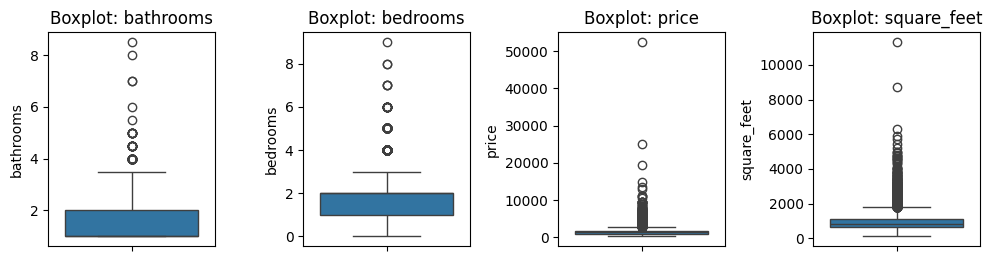

In [20]:
# Menentukan kolom numerik yang akan dianalisis untuk outlier
fitur_numerik = ['bathrooms', 'bedrooms', 'price', 'square_feet']

# Visualisasi boxplot untuk mendeteksi outlier pada masing-masing kolom
plt.figure(figsize=(10, 5))
for idx, fitur in enumerate(fitur_numerik, 1):
    plt.subplot(2, 4, idx)
    sns.boxplot(y=cleaned_df[fitur])
    plt.title(f'Boxplot: {fitur}')

plt.tight_layout()
plt.show()


| Fitur        | Outlier | Distribusi    | Rekomendasi Tambahan            |
| ------------ | ------- | ------------- | ------------------------------- |
| bathrooms    | Ya      | Skewed        | IQR atau batas atas logis       |
| bedrooms     | Ya      | Skewed        | Normalisasi atau kategorisasi   |
| price        | Ya      | Sangat skewed | Transformasi log atau trimming  |
| square\_feet | Ya      | Sangat skewed | Transformasi log dan pembatasan |


### ⚠️ Menghapus Outlier
Menggunakan metode IQR untuk membersihkan data dari nilai-nilai ekstrem.

In [21]:
#Fungsi untuk menghapus outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

#Daftar kolom yang akan diatasi outliersnya
numeric_columns = ['bathrooms', 'bedrooms', 'price','square_feet']

#Menghapus outliers dari masing-masing kolom
for column in numeric_columns:
    train_df_cleaned = remove_outliers_iqr(cleaned_df, column)

# Verifikasi hasil
cleaned_df.shape

(9883, 22)

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

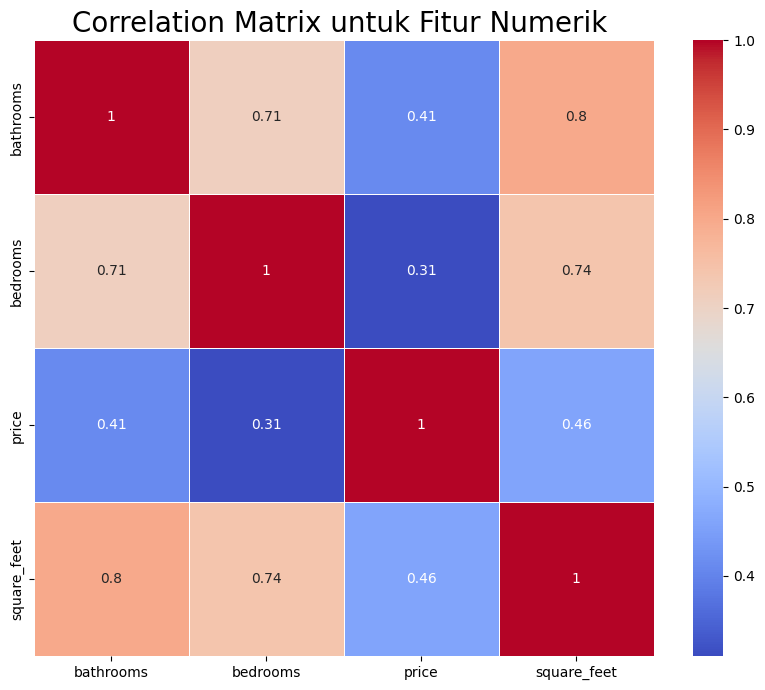

In [28]:
#Menampilkan heatmap untuk korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
correlation_matrix = cleaned_df[numeric_columns].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

|                  | bathrooms | bedrooms | price | square\_feet |
| ---------------- | --------- | -------- | ----- | ------------ |
| **bathrooms**    | 1.00      | 0.71     | 0.41  | 0.80         |
| **bedrooms**     | 0.71      | 1.00     | 0.31  | 0.74         |
| **price**        | 0.41      | 0.31     | 1.00  | 0.46         |
| **square\_feet** | 0.80      | 0.74     | 0.46  | 1.00         |


**Feature Engineering**

### 🧹 Penghapusan Kolom atau Baris
Menghapus kolom/baris yang dianggap tidak relevan atau memiliki banyak missing value.

In [29]:
features_to_drop = ['id', 'category','title', 'body','currency', 'fee','price_display','price_type','address','latitude','longitude','time']
cleaned_df = cleaned_df.drop(columns=features_to_drop)

### 🧹 Penghapusan Kolom atau Baris
Menghapus kolom/baris yang dianggap tidak relevan atau memiliki banyak missing value.

In [30]:
# Mengonversi kolom-kolom kategorikal menjadi representasi numerik one-hot encoding
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['amenities'], prefix='amenities')], axis=1)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['has_photo'], prefix='has_photo')], axis=1)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['pets_allowed'], prefix='pets_allowed')], axis=1)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['cityname'], prefix='cityname')], axis=1)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['state'], prefix='state')], axis=1)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df['source'], prefix='source')], axis=1)

# Menghapus kolom-kolom aslinya karena telah dikonversi menjadi bentuk numerik
cleaned_df.drop(['amenities', 'has_photo', 'pets_allowed', 'cityname', 'state', 'source'], axis=1, inplace=True)

# Menampilkan lima baris pertama dari DataFrame yang telah diproses
cleaned_df.head()


,bathrooms,bedrooms,price,square_feet,amenities_AC,"amenities_AC,Alarm,Cable or Satellite,Clubhouse,Dishwasher,Fireplace,Garbage Disposal,Internet Access,Parking,Patio/Deck,Playground,Refrigerator,Washer Dryer","amenities_AC,Alarm,Cable or Satellite,Clubhouse,Dishwasher,Fireplace,Gym,Internet Access,Patio/Deck,Refrigerator,Storage,Tennis,Washer Dryer","amenities_AC,Alarm,Cable or Satellite,Clubhouse,Dishwasher,Fireplace,Gym,Internet Access,Pool,Refrigerator,Storage,TV,Wood Floors","amenities_AC,Alarm,Cable or Satellite,Dishwasher,Fireplace,Gated,Gym,Parking,Patio/Deck,Playground,Pool,Refrigerator,Washer Dryer","amenities_AC,Alarm,Cable or Satellite,Dishwasher,Internet Access,Patio/Deck,Washer Dryer",...,source_Listanza,source_ListedBuy,source_RENTCafé,source_RENTOCULAR,source_Real Estate Agent,source_RealRentals,source_RentDigs.com,source_RentLingo,source_rentbits,source_tenantcloud
2,1.0,0.0,1390,107,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1.0,0.0,925,116,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,1.0,0.0,2475,130,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
8,1.0,0.0,1495,138,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
14,1.0,0.0,1695,190,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [31]:
# # Ubah hanya kolom bertipe boolean menjadi 0 dan 1
# bool_cols = cleaned_df.select_dtypes(include='bool').columns
# cleaned_df[bool_cols] = cleaned_df[bool_cols].astype(int)


### 🧹 Penghapusan Kolom atau Baris
Menghapus kolom/baris yang dianggap tidak relevan atau memiliki banyak missing value.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Misal cleaned_df sudah tersedia
X = cleaned_df.drop(["price"], axis=1)
y = cleaned_df["price"]

# Membagi data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standarisasi fitur numerik
numerical_features = ['bathrooms', 'bedrooms', 'square_feet']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_train[numerical_features].head()


,bathrooms,bedrooms,square_feet
5539,-0.619757,1.326634,-0.181302
2501,-0.619757,-0.792871,-0.555580
5318,-0.619757,0.266882,-0.209234
3280,-0.619757,-0.792871,-0.464338
143,-0.619757,-0.792871,-1.298547


## 5.Model dan evaluasi
Proyek ini menggunakan tiga jenis model machine learning dengan tujuan yang berbeda namun saling melengkapi:

---




### 1.  Content-Based Filtering


---

### 🔧 Proses Analisis/Data Preparation
Menjalankan proses transformasi atau analisis data.

In [33]:
# Check for non-positive values
non_positive_values = cleaned_df['price'] <= 0
print("Number of non-positive values in 'price':", non_positive_values.sum())

Number of non-positive values in 'price': 0


### 🧹 Penghapusan Kolom atau Baris
Menghapus kolom/baris yang dianggap tidak relevan atau memiliki banyak missing value.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler

# Pisahkan fitur dan target
X = cleaned_df.drop('price', axis=1)
y = cleaned_df['price']

# Transformasi target menggunakan PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).flatten()  # Hasil transformasi dikembalikan ke bentuk 1D

# Bagi data menjadi data latih dan data uji (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# Standarisasi fitur numerik
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# (Opsional) Cetak bentuk data sebagai verifikasi
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (7906, 3888)
X_test shape: (1977, 3888)
y_train shape: (7906,)
y_test shape: (1977,)


### 🤖 Melatih Model
Melatih model machine learning dengan data yang telah disiapkan.

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# Daftar model
models = {
    'ridge': Ridge(),
    'xgboost': XGBRegressor(verbosity=0),
    'catboost': CatBoostRegressor(verbose=0),
    'lightgbm': LGBMRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'lasso': Lasso(),
    'random forest': RandomForestRegressor(),
    'bayesian ridge': BayesianRidge(),
    'support vector': SVR(),
    'knn': KNeighborsRegressor(n_neighbors=4)
}

# Data evaluasi
results = []

# Training dan evaluasi masing-masing model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

# Hasil evaluasi sebagai DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 7906, number of used features: 161
[LightGBM] [Info] Start training from score 0.000854


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



### 📏 Evaluasi Model
Mengukur performa model dengan metrik seperti RMSE atau MSE.

Hasil Evaluasi Model Regresi:

               Model      RMSE       MAE  R2 Score
1            xgboost  0.519137  0.376214  0.724485
2           catboost  0.524123  0.383808  0.719167
6      random forest  0.535067  0.380173  0.707317
3           lightgbm  0.550051  0.399086  0.690695
7     bayesian ridge  0.576577  0.407971  0.660142
0              ridge  0.607665  0.420291  0.622506
4  gradient boosting  0.616096  0.464482  0.611959
8     support vector  0.637251  0.453042  0.584852
9                knn  0.749855  0.550691  0.425175
5              lasso  0.989039  0.777433 -0.000019


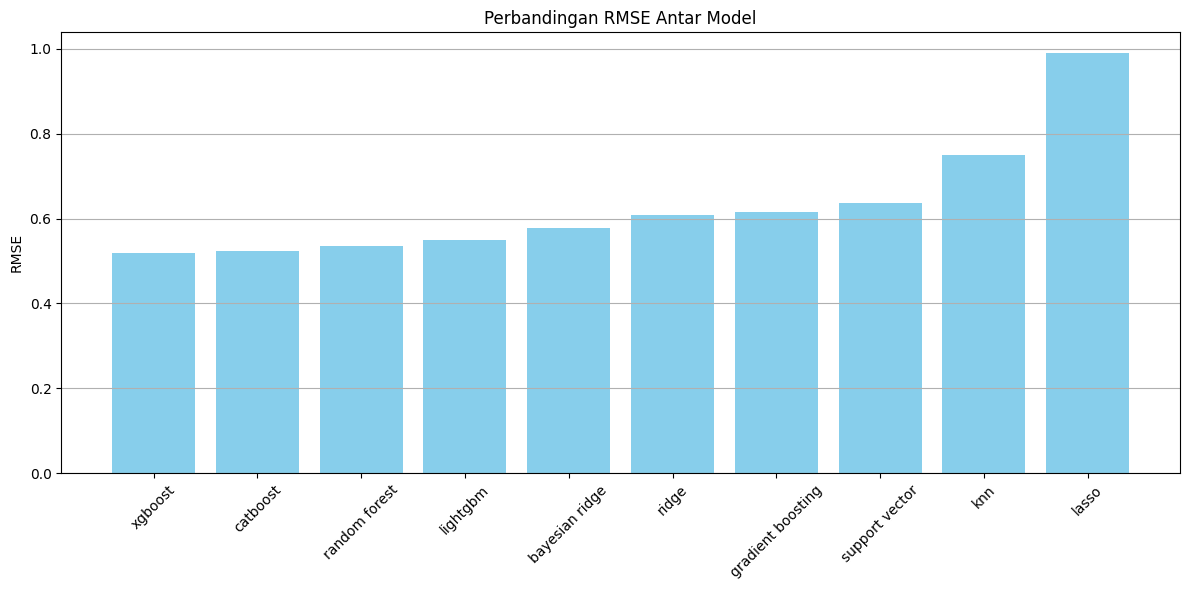

In [39]:
# Menampilkan hasil evaluasi
print("Hasil Evaluasi Model Regresi:\n")
print(results_df)

# (Opsional) Visualisasi perbandingan performa
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.title('Perbandingan RMSE Antar Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


| Tujuan                      | Rekomendasi                                                                 |
| --------------------------- | --------------------------------------------------------------------------- |
| Model yang akan digunakan   | Gunakan **XGBoost** sebagai baseline terbaik untuk deployment               |
| Model pembanding (baseline) | Gunakan **Ridge** dan **Random Forest** untuk validasi model linear vs tree |
| Optimasi lebih lanjut       | Lakukan **hyperparameter tuning** pada top 3 model (XGBoost, CatBoost, RF)  |
| Model yang bisa dihapus     | Pertimbangkan untuk **tidak menggunakan Lasso dan KNN** di iterasi lanjutan |


### 🔮 Melakukan Prediksi
Menggunakan model untuk memprediksi harga berdasarkan fitur input.

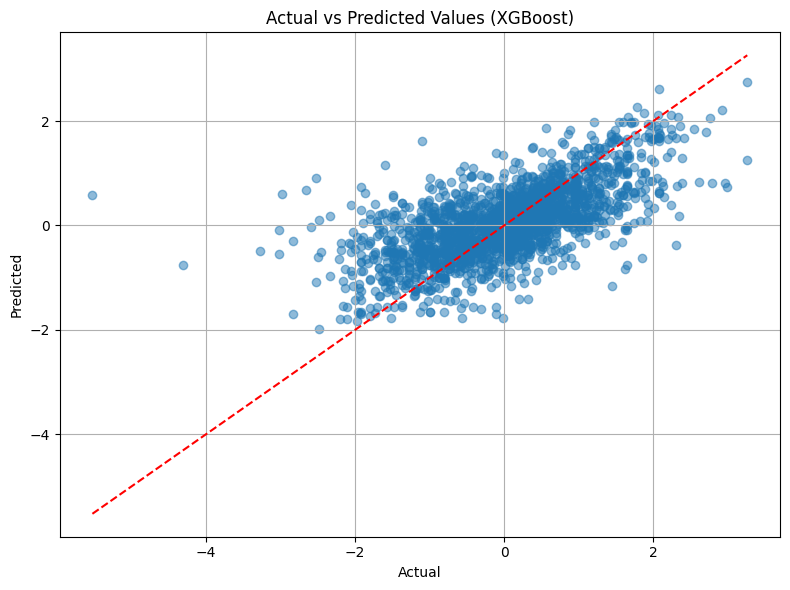

In [45]:
# Plot 1: Scatter plot (Predicted vs Actual)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (XGBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Penutup

